<a href="https://colab.research.google.com/github/addo561/learning-pytorch/blob/main/Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
!pip install opendatasets

In [75]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/sanikamal/rock-paper-scissors-dataset/data')

Skipping, found downloaded files in "./rock-paper-scissors-dataset" (use force=True to force download)


In [76]:
import torch
from torch import nn
import torchvision
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

print(f'Version: {torch.__version__}')

Version: 2.6.0+cu124


In [77]:
transform = transforms.Compose([
    transforms.Resize(28),
    #transforms.CenterCrop(28),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [78]:
#images
Train_dataset = torchvision.datasets.ImageFolder(root='/content/rock-paper-scissors-dataset/Rock-Paper-Scissors/train',transform=transform)
Test_dataset = torchvision.datasets.ImageFolder(root='/content/rock-paper-scissors-dataset/Rock-Paper-Scissors/test',transform=transform)


In [79]:
Train_dataset

Dataset ImageFolder
    Number of datapoints: 2520
    Root location: /content/rock-paper-scissors-dataset/Rock-Paper-Scissors/train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=bilinear, max_size=None, antialias=True)
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [80]:
class_names = Train_dataset.classes
class_names

['paper', 'rock', 'scissors']

In [81]:
Train_dataset.class_to_idx

{'paper': 0, 'rock': 1, 'scissors': 2}

In [82]:
#Building dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(Train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(Test_dataset,batch_size=32,shuffle=True)

In [83]:
feature_batch,label_batch = next(iter(train_loader))
feature_batch.shape,label_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [84]:
random_idx = torch.randint(0,len(feature_batch),size=[1]).item()
random_idx

11

image size: torch.Size([1, 28, 28])
label: 2


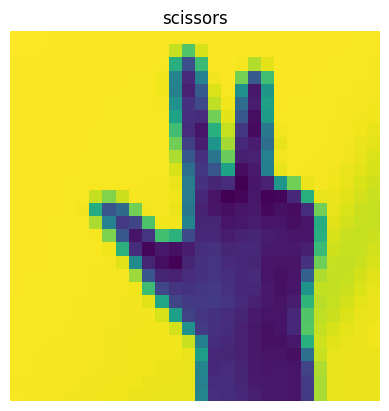

In [85]:
#view images
torch.manual_seed(42)
random_idx = torch.randint(0,len(feature_batch),size=[1]).item()
img,label = feature_batch[random_idx],label_batch[random_idx]
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis('off')
print(f'image size: {img.shape}')
print(f'label: {label}')


In [86]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [87]:
#timer
from timeit import default_timer as timer
def print_time(start,end,device):
  time= end-start
  return f'time: {time}'

In [88]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [89]:
#create evaluation func
from helper_functions import accuracy_fn
def eval(model,dataloader,loss_fn,accuracy_fn):
  loss,acc =0,0
  model.eval()
  with torch.inference_mode():
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)

      loss +=loss_fn(pred,y)
      acc += accuracy_fn(y_true = y,y_pred=pred.argmax(dim=1))

    loss /= len(dataloader)
    acc /= len(dataloader)
  return {'model_name':model.__class__.__name__,
          'model_loss':loss.item(),
          'model_acc':acc}

In [90]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [91]:
# Create a convolutional neural network
class RPS(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model = RPS(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model

RPS(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=3, bias=True)
  )
)

In [95]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.01)


In [96]:
from tqdm import tqdm
#train
torch.manual_seed(42)
# Measure time
from timeit import default_timer as timer
train_time_start_model= timer()

epochs = 7
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
  test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)
total_train_time_model


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.01487 | Train accuracy: 99.60%


 14%|█▍        | 1/7 [00:15<01:30, 15.09s/it]

Test loss: 2.06412 | Test accuracy: 67.76%

Epoch: 1
---------
Train loss: 0.01190 | Train accuracy: 99.68%


 29%|██▊       | 2/7 [00:29<01:13, 14.65s/it]

Test loss: 2.11287 | Test accuracy: 68.23%

Epoch: 2
---------
Train loss: 0.01066 | Train accuracy: 99.72%


 43%|████▎     | 3/7 [00:43<00:57, 14.45s/it]

Test loss: 2.19778 | Test accuracy: 67.14%

Epoch: 3
---------
Train loss: 0.00968 | Train accuracy: 99.72%


 57%|█████▋    | 4/7 [00:58<00:43, 14.43s/it]

Test loss: 2.22221 | Test accuracy: 67.45%

Epoch: 4
---------
Train loss: 0.00893 | Train accuracy: 99.72%


 71%|███████▏  | 5/7 [01:13<00:29, 14.87s/it]

Test loss: 2.26366 | Test accuracy: 66.77%

Epoch: 5
---------
Train loss: 0.00838 | Train accuracy: 99.72%


 86%|████████▌ | 6/7 [01:30<00:15, 15.43s/it]

Test loss: 2.27870 | Test accuracy: 67.76%

Epoch: 6
---------
Train loss: 0.00785 | Train accuracy: 99.72%


100%|██████████| 7/7 [01:44<00:00, 14.91s/it]

Test loss: 2.42215 | Test accuracy: 68.49%



'time: 104.38067136199993'

In [94]:
eval(model,test_loader,loss_fn,accuracy_fn)

{'model_name': 'RPS',
 'model_loss': 1.9639643430709839,
 'model_acc': 70.67708333333333}

In [102]:
#draw  confusion matrix
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
#The y_preds variable is a list of tensors. To create a single tensor containing all predictions, use torch.cat to concatenate these tensors along dimension 0.
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/12 [00:00<?, ?it/s]

<ipython-input-104-6cbb9c0785d2>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  confmat_tensor = confmat(preds=torch.tensor(y_pred_tensor), target=torch.tensor(Test_dataset.targets))


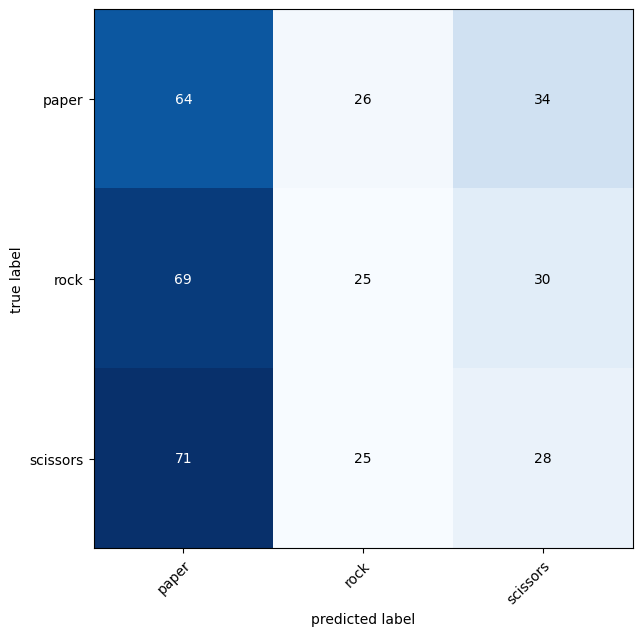

In [104]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=torch.tensor(y_pred_tensor), target=torch.tensor(Test_dataset.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);